In [1]:
import gc
import os
import utm
import h5py
import time as time
import pandas as pd
import geopy.distance as geo
import seisbench.models as sbm

from tqdm import tqdm
from obspy import read_events
from obspy.taup import TauPyModel
from distaz import DistAz
from joblib import Parallel, delayed
from collections import OrderedDict
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

from das_util import try_gpu
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from ELEP.elep.ensemble_coherence import ensemble_semblance 

import numpy as np
from numpy.random import default_rng

import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.utils.data import DataLoader

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

### Read earthquake metadata

In [2]:
qml = '/fd1/QibinShi_data/akdas/qibin_data/ak_Dec1_31.xml'
cat = read_events(qml)
mag = []
for evt in cat:
    mag.append(evt.magnitudes[0].mag)

# Earthquake detection using 4500 Channels

### Read the picks and concatenate

In [3]:
with h5py.File('./plots_test_picking_dec_ch4500/picks_cat_0_200.hdf5', 'r') as f:
    raw_alldata_picks1 = f["raw_alldata_picks"][:]
    one_denoise_picks1 = f["one_denoise_picks"][:]
    mul_denoise_picks1 = f["mul_denoise_picks"][:] 
    snr_raw1 = f["raw_alldata_snr"][:] 
    snr_one1 = f["one_denoise_snr"][:] 
    snr_mul1 = f["mul_denoise_snr"][:] 
    npk_raw1 = f["raw_alldata_numpick"][:] 
    npk_one1 = f["one_denoise_numpick"][:]
    npk_mul1 = f["mul_denoise_numpick"][:]
    
with h5py.File('./plots_test_picking_dec_ch4500/picks_cat_200_400.hdf5', 'r') as f:
    raw_alldata_picks2 = f["raw_alldata_picks"][:]
    one_denoise_picks2 = f["one_denoise_picks"][:]
    mul_denoise_picks2 = f["mul_denoise_picks"][:] 
    snr_raw2 = f["raw_alldata_snr"][:] 
    snr_one2 = f["one_denoise_snr"][:] 
    snr_mul2 = f["mul_denoise_snr"][:] 
    npk_raw2 = f["raw_alldata_numpick"][:] 
    npk_one2 = f["one_denoise_numpick"][:]
    npk_mul2 = f["mul_denoise_numpick"][:]
    
with h5py.File('./plots_test_picking_dec_ch4500/picks_cat_400_555.hdf5', 'r') as f:
    raw_alldata_picks3 = f["raw_alldata_picks"][:]
    one_denoise_picks3 = f["one_denoise_picks"][:]
    mul_denoise_picks3 = f["mul_denoise_picks"][:] 
    snr_raw3 = f["raw_alldata_snr"][:] 
    snr_one3 = f["one_denoise_snr"][:] 
    snr_mul3 = f["mul_denoise_snr"][:] 
    npk_raw3 = f["raw_alldata_numpick"][:] 
    npk_one3 = f["one_denoise_numpick"][:]
    npk_mul3 = f["mul_denoise_numpick"][:]
    
raw_alldata_picks = np.concatenate((raw_alldata_picks1, raw_alldata_picks2, raw_alldata_picks3))
one_denoise_picks = np.concatenate((one_denoise_picks1, one_denoise_picks2, one_denoise_picks3))
mul_denoise_picks = np.concatenate((mul_denoise_picks1, mul_denoise_picks2, mul_denoise_picks3))
snr_raw = np.concatenate((snr_raw1, snr_raw2, snr_raw3))
snr_one = np.concatenate((snr_one1, snr_one2, snr_one3))
snr_mul = np.concatenate((snr_mul1, snr_mul2, snr_mul3))
npk_raw = np.concatenate((npk_raw1, npk_raw2, npk_raw3))
npk_one = np.concatenate((npk_one1, npk_one2, npk_one3))
npk_mul = np.concatenate((npk_mul1, npk_mul2, npk_mul3))

### Histogram for the number of picks

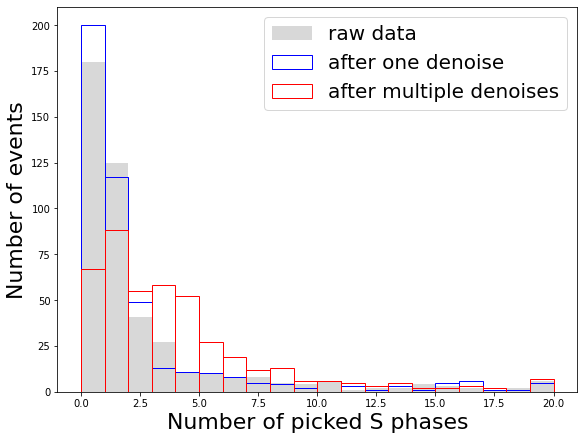

In [7]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(npk_raw,bins=20,color='gray',alpha=0.3, range=(0,20), label='raw data')
plt.hist(npk_one,bins=20,edgecolor='blue', fill=False, range=(0,20), label='after one denoise')
plt.hist(npk_mul,bins=20,edgecolor='red', fill=False, range=(0,20), label='after multiple denoises')

plt.xlabel("Number of picked S phases", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

In [ ]:
a=-1
b=0.65

indmag > 10 ** (a + b * np.log10(rad)) 

### number of picks vs magnitudes

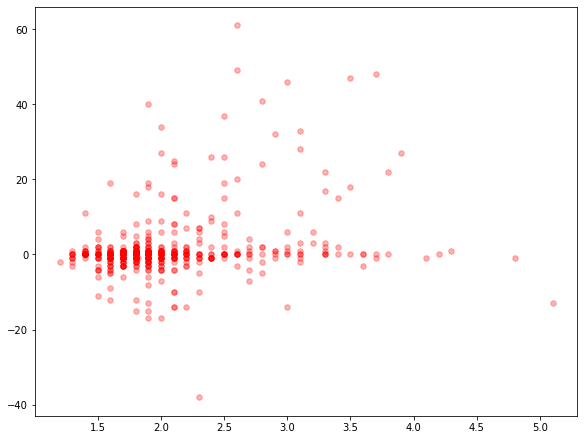

In [9]:
plt.figure(figsize=(8, 6), constrained_layout=True)
# plt.scatter(mag, npk_raw, s=30,marker='o',c='gray',alpha=0.3)
# plt.scatter(mag, npk_one, s=30,marker='o',c='blue',alpha=0.3)
plt.scatter(mag, npk_one-npk_raw, s=30,marker='o',c='red',alpha=0.3)
# plt.xscale('log')
# plt.yscale('log')

# Earthquake detection using 1500 Channels

### Read the output data

In [3]:
with h5py.File('./plots_test_picking_dec_ch1500/pick_stats.hdf5', 'r') as f:
    raw_alldata_picks = f["raw_alldata_picks"][:]
    one_denoise_picks = f["one_denoise_picks"][:]
    mul_denoise_picks = f["mul_denoise_picks"][:] 
    snr_raw = f["raw_alldata_snr"][:] 
    snr_one = f["one_denoise_snr"][:] 
    snr_mul = f["mul_denoise_snr"][:] 
    npk_raw = f["raw_alldata_numpick"][:] 
    npk_one = f["one_denoise_numpick"][:]
    npk_mul = f["mul_denoise_numpick"][:]
    std_raw = f["raw_alldata_pickerr"][:] 
    std_one = f["one_denoise_pickerr"][:]
    std_mul = f["mul_denoise_pickerr"][:]

### Number of phase picks

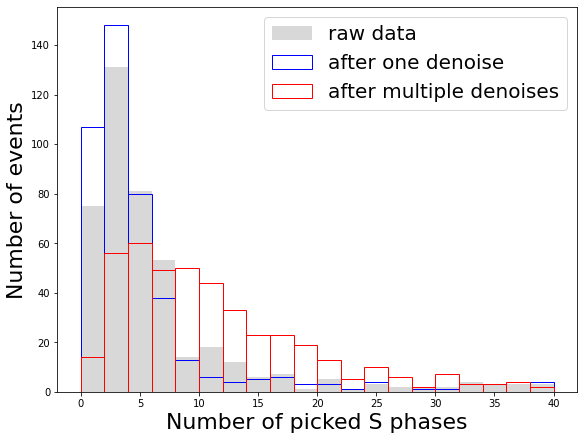

In [8]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(npk_raw[:,1],bins=20,color='gray',alpha=0.3, range=(0,40), label='raw data')
plt.hist(npk_one[:,1],bins=20,edgecolor='blue', fill=False, range=(0,40), label='after one denoise')
plt.hist(npk_mul[:,1],bins=20,edgecolor='red', fill=False, range=(0,40), label='after multiple denoises')

plt.xlabel("Number of picked S phases", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

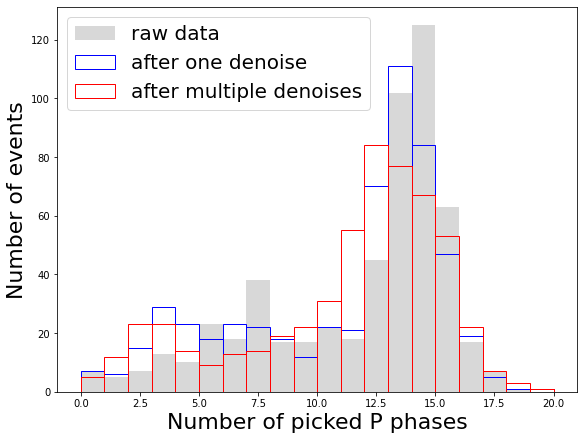

In [11]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(std_raw[:,0],bins=20,color='gray',range=(0,20),alpha=0.3, label='raw data')
plt.hist(std_one[:,0],bins=20,edgecolor='blue',range=(0,20), fill=False,label='after one denoise')
plt.hist(std_mul[:,0],bins=20,edgecolor='red', range=(0,20), fill=False,  label='after multiple denoises')

plt.xlabel("Number of picked P phases", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

### SNR based on picked phases

/tmp/ipykernel_26589/3710461810.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.hist(20*np.log10(snr_raw[:,1]),bins=30,color='gray',alpha=0.3,range=(0,20),label='raw data')
/tmp/ipykernel_26589/3710461810.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.hist(20*np.log10(snr_one[:,1]),bins=30,edgecolor='blue', fill=False, range=(0,20),label='after one denoise')
/tmp/ipykernel_26589/3710461810.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist(20*np.log10(snr_mul[:,1]),bins=30,edgecolor='red', fill=False, range=(0,20),label='after multiple denoises')


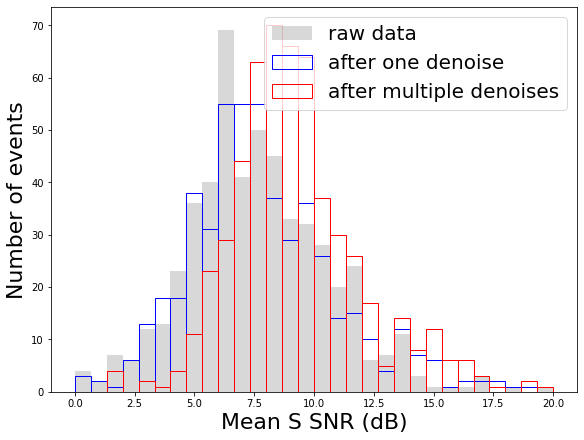

In [12]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(20*np.log10(snr_raw[:,1]),bins=30,color='gray',alpha=0.3,range=(0,20),label='raw data')
plt.hist(20*np.log10(snr_one[:,1]),bins=30,edgecolor='blue', fill=False, range=(0,20),label='after one denoise')
plt.hist(20*np.log10(snr_mul[:,1]),bins=30,edgecolor='red', fill=False, range=(0,20),label='after multiple denoises')

plt.xlabel("Mean S SNR (dB)", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

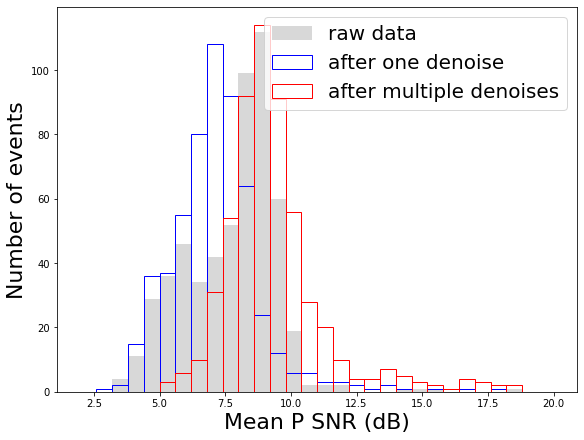

In [13]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(20*np.log10(snr_raw[:,0]),bins=30,color='gray',alpha=0.3,range=(2,20),label='raw data')
plt.hist(20*np.log10(snr_one[:,0]),bins=30,edgecolor='blue', fill=False, range=(2,20),label='after one denoise')
plt.hist(20*np.log10(snr_mul[:,0]),bins=30,edgecolor='red', fill=False,range=(2,20), label='after multiple denoises')

plt.xlabel("Mean P SNR (dB)", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

### Standard error of phase time

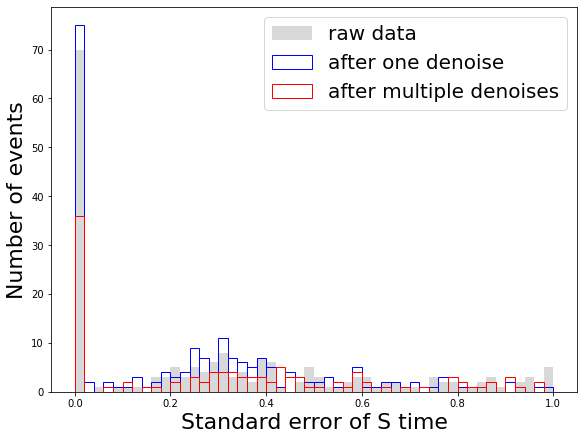

In [14]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(std_raw[:,1],bins=50,color='gray',alpha=0.3, range=(0,1), label='raw data')
plt.hist(std_one[:,1],bins=50,edgecolor='blue', fill=False, range=(0,1), label='after one denoise')
plt.hist(std_mul[:,1],bins=50,edgecolor='red', fill=False, range=(0,1), label='after multiple denoises')

plt.xlabel("Standard error of S time", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

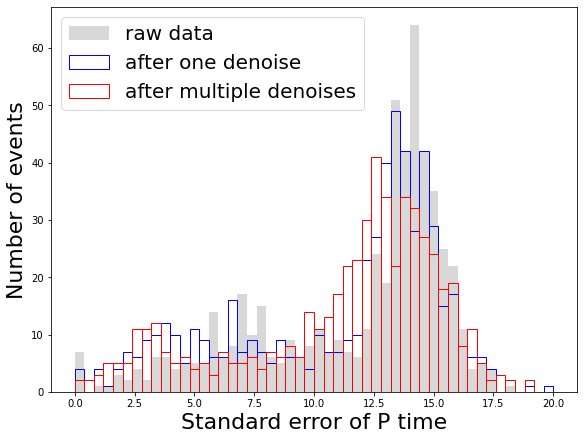

In [15]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.hist(std_raw[:,0],bins=50,color='gray',alpha=0.3, range=(0,20), label='raw data')
plt.hist(std_one[:,0],bins=50,edgecolor='blue', fill=False, range=(0,20), label='after one denoise')
plt.hist(std_mul[:,0],bins=50,edgecolor='red', fill=False, range=(0,20), label='after multiple denoises')

plt.xlabel("Standard error of P time", fontsize=22)
plt.ylabel("Number of events", fontsize=22)
plt.legend(fontsize=20)

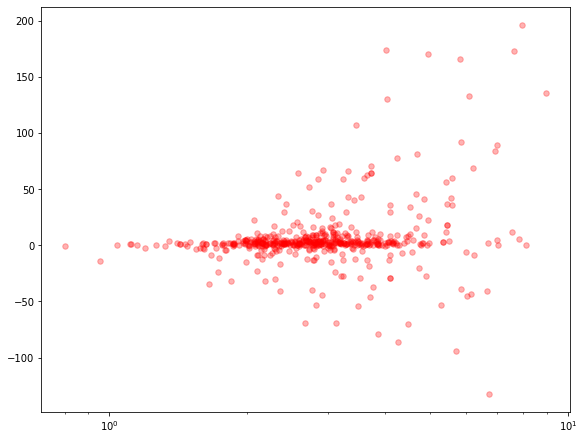

In [20]:
plt.figure(figsize=(8, 6), constrained_layout=True)
# plt.scatter(mag, npk_raw, s=30,marker='o',c='gray',alpha=0.3)
# plt.scatter(mag, npk_one, s=30,marker='o',c='blue',alpha=0.3)
plt.scatter(snr_mul, npk_mul-npk_raw, s=30,marker='o',c='red',alpha=0.3)
plt.xscale('log')
# plt.yscale('log')
# plt.hist(npk_one,bins=20,color='gray')